# Домашнее задание 1. Дистиляция и ускорение моделей.

## 1. Выбор модели и контекста применения

В данной работе я рассматрю задачу генерации изображений по текстовому описанию. В качестве базовой модели я выбрала Stable Diffusion v1.5 — диффузионную нейросетевую модель, предназначенную для генерации или редактирования изображений по текстовому запросу. Модель используется в режиме инференса, без дополнительного обучения, и предполагается её запуск в офлайн-сценарии на мобильном устройстве без подключения к сети Интернет. Основной целевой сценарий — локальная генерация изображений по запросу пользователя.

**Характеристики сценария использования:**

- Режим работы: инференс (без дополнительного обучения модели)

- Тип использования: офлайн

- Целевая платформа: мобильный телефон Xiaomi 15 

- Частота запросов: низкая (единицы генераций за сессию пользователя)

- Объём входных данных: короткий текстовый запрос (несколько слов или предложений)

- Объём выходных данных: одно изображение фиксированного разрешения

- Требования к задержке: допустима генерация изображения в течение десятков секунд

- Основные ограничения: объём доступной памяти, время работы и энергопотребление

## 2. Целевая аппаратная платформа

**Целевое устройство:** смартфон **Xiaomi 15**

* **Система-на-чипе (SoC):** Qualcomm Snapdragon 8 Elite (3 нм) —  мобильный чип с архитектурой ARM, объединяющий CPU, GPU и AI-ускоритель(Qualcomm AI Engine).
* **CPU:** восьмиядерный ARM-процессор с двумя ядрами и шестью энергоэффективными ядрами, частоты до 4.32 GHz. 
* **GPU:** Adreno 830 — мобильное графическое ядро для рендеринга и ускорения вычислений. 
* **Память:** до **12–16 GB LPDDR5X RAM** и высокоскоростное **UFS 4.0** хранилище. На моем телефоне 12 Gb.
* **ОС:** Android 15 с оболочкой HyperOS 2. 

Стоит заметить, что хотя смартфон Xiaomi 15 оснащён ARM‑CPU и GPU Adreno, PyTorch Mobile не использует Adreno напрямую, а CUDA отсутствует; AI-ускоритель доступен только через специализированные runtime‑фреймворки (NNAPI, TFLite, ONNX), поэтому инференс тяжёлых моделей на CPU/GPU значительно медленнее, чем на настольном GPU. Объём физической памяти 12 ГБ ограничен системой и фоновыми процессами, а для моделей, таких как Stable Diffusion v1.5, требуется дополнительная память для активаций, что делает запуск «из коробки» проблематичным. Мобильные CPU/GPU имеют меньшую пропускную способность для матричных операций и attention, из-за чего задержки генерации могут достигать нескольких минут. Кроме того, интенсивные вычисления сильно расходуют батарею и вызывают нагрев и троттлинг, что дополнительно ограничивает интерактивное использование модели.



## 3. Архитектура модели



Импортирую модель и выведу части пайплайна.

In [1]:
import torch
from diffusers import StableDiffusionPipeline

# --- Настройка устройства ---
device = "cpu"
print("Using device:", device)

# --- Загружаем модель ---
pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",  # SD 1.5
    torch_dtype=torch.float32
).to(device)

pipe

2026-02-05 12:35:18.419336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770294918.633554     229 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770294918.700525     229 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770294919.236932     229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770294919.236983     229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770294919.236986     229 computation_placer.cc:177] computation placer alr

Using device: cpu


Couldn't connect to the Hub: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/models/stable-diffusion-v1-5/stable-diffusion-v1-5.
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.35.2",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Stable Diffusion — это **модель диффузии для генерации и редактирования изображений по текстовому описанию**. На высоком уровне её блоки:

1. **Text Encoder (CLIPTextModel)**

   * Преобразует текстовый промт в векторное представление (эмбеддинги).
   * Слои: трансформер (multi-head attention + feed-forward).
   * Ресурсоёмкость: attention на длинных последовательностях, но меньше UNet по памяти.

2. **UNet (UNet2DConditionModel)**

   * Основной генеративный блок, который строит изображение в латентном пространстве. Вызывается несколько раз.
   * Слои:  ResNet блоки, attention-блоки (cross-attention на текстовые эмбеддинги)
   * **Главный ресурсный узел**: attention и свёртки потребляют больше всего памяти и вычислений, особенно из-за многократного вызова.

3. **VAE (AutoencoderKL)**

   * На инференсе используется только декодер.
   * Декодирует латентное представление в финальное изображение.
   * Слои: Conv2d, residual blocks, нормализация.
   * Ресурсоёмкость умеренная.

4. **Scheduler (PNDMScheduler)**

   * Управляет шагами диффузии при генерации изображения.
   * Ресурсоёмкость низкая.

5. **Safety Checker + Feature Extractor**

   * Проверяют сгенерированные изображения на потенциально нежелательный контент.
   * Ресурсоёмкость низкая.

**Ключевые ресурсоёмкие части**

| Блок         | Почему ресурсоёмкий                                                                                  |
| ------------ | ---------------------------------------------------------------------------------------------------- |
| UNet         | Большие тензоры latent space, много свёрток и attention; основной bottleneck по памяти, времени и вычислениям |
| Text Encoder | Cross-attention с UNet, особенно для длинных промтов                                                 |
| VAE          | Декодирование латентного тензора в изображение (память умеренная, вычисления — средние)              |


## 4. Вычислительные затраты и узкие места



Сначала попробую запустить модель с каким-то промтом и посмотрю какую картинку она сгенерирует.

In [2]:
# --- Пробный промт ---
prompt = "A watercolor painting of a fantasy landscape with river and fantastic flowers"

# --- Генерация картинки ---
with torch.autocast(device) if device=="cuda" else torch.no_grad():
    output = pipe(prompt=prompt, height=256, width=256, guidance_scale=5)  # маленький размер и шаги для быстрого теста

image = output.images[0]
image.save("output_sd_test.png")

  0%|          | 0/50 [00:00<?, ?it/s]

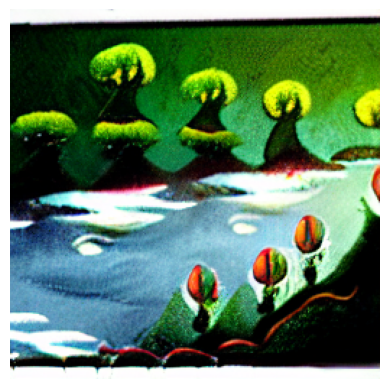

In [3]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis("off")
plt.show()

Качество картинки неплохое, но содержание не совсем соответствует промту(не совсем похоже на акварель). Это обучловлено небольшим размером модели.

Далее запущу профайлер на всем пайплайне для того чтобы определить вычислительные затраты и узкие места. Запускаю на CPU, так как CUDA недоступен на телефоне. 

In [6]:
import torch.profiler

# --- Функция генерации для профайлера ---
def generate_sd():
    return pipe(prompt=prompt, height=256, width=256)

# --- Профилирование ---
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU
    ],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    generate_sd()

# --- Вывод отчёта ---
print("Sorted by time usage")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))
print("Sorted by memory usage")
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=20))

  0%|          | 0/50 [00:00<?, ?it/s]

Sorted by time usage
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         aten::conv2d         0.04%      77.843ms        56.94%      102.798s      20.417ms       6.34 GB           0 B          5035  
                                    aten::convolution         0.07%     125.323ms        56.90%      102.720s      20.401ms       6.34 GB           0 B          5035  
                                   aten::_convolution         0.06%      99.530ms        56.83%      102.595s      20.376ms       6.34 GB  

### Весь пайплайн 

**Основные потребители времени**

* **Свёртки (aten::mkldnn_convolution / conv2d / convolution)** - **~56–57% self CPU time**
  Это основной bottleneck по времени. Свёртки выполняются в U-Net на каждом шаге диффузии и в VAE, работают с большими feature maps.

* **Линейные и матричные операции (aten::addmm / linear / mm / matmul)** - **~30–31% self CPU time**
  Используются в:

  * self- и cross-attention (Q/K/V, projection),
  * проекционных слоях U-Net,
  * Transformer-блоках text encoder.
    На CPU это большое количество плотных матричных умножений без специализированного ускорения.

* **Attention (scaled_dot_product_attention + flash_attention_for_cpu)** - **~5-6% CPU total time**
  Хотя attention логически «включает» matmul, в профайлере он выделяется как отдельный fused kernel. На CPU flash attention всё равно сводится к матричным операциям и доступу к памяти.

**Основные потребители памяти**

* **aten::empty** — **~17.6 GB (CPU Mem)**
  Массовое динамическое выделение временных тензоров (буферы, intermediate activations). Это главный индикатор давления на память.

* **Линейные операции (aten::linear / addmm)** —

  * linear: **~17.5 GB (CPU Mem)**
  * addmm: **~12.3 GB, ~6.9 GB (CPU Mem)**
    Большие промежуточные матрицы в attention и projection слоях, повторяющиеся на каждом шаге диффузии.

* **Свёртки (conv / mkldnn_convolution)** — **~6.3 GB**
  Feature maps U-Net и VAE, особенно на ранних слоях с высоким разрешением.

* **Операции суммирования и активации (add, gelu, silu, mul)** — **3–7 GB**
  Residual connections и нелинейности поверх больших тензоров.


  Общие узкие места напишу ниже после анализа отдельных частей архитектуры.


Теперь запущу профайлер отдельно на каждой из больших частей модели.

In [4]:
height, width = 256, 256

# --- 1. Подготовка эмбеддингов текста ---
def encode_text():
    inputs = pipe.tokenizer(prompt, return_tensors="pt").to(device)
    text_embeddings = pipe.text_encoder(**inputs).last_hidden_state
    return text_embeddings

# --- 2. UNet инференс ---
def unet_inference(latent, text_embeddings):
    scheduler = pipe.scheduler
    latents = latent
    for t in scheduler.timesteps[:50]:
        latents = pipe.unet(latents, t, encoder_hidden_states=text_embeddings).sample
    return latents

# --- 3. VAE декодирование ---
def decode_latent(latents):
    image = pipe.vae.decode(latents).sample
    return image

# --- Профилирование Text Encoder отдельно ---
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU],
    record_shapes=True,
    profile_memory=True
) as prof_encoder:
    text_embeddings = encode_text()  # вызов энкодера

print("=== Text Encoder only ===")
print("Sorted by time usage")
print(prof_encoder.key_averages().table(sort_by="cpu_time_total", row_limit=20))
print("Sorted by memory usage")
print(prof_encoder.key_averages().table(sort_by="cpu_memory_usage", row_limit=20))


# --- Профилирование UNet отдельно ---
latents = torch.randn((1, pipe.unet.config.in_channels, height // 8, width // 8), device=device)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU],
    record_shapes=True,
    profile_memory=True
) as prof_unet:
    unet_inference(latents, text_embeddings)

print("=== UNet only ===")
print("Sorted by time usage")
print(prof_unet.key_averages().table(sort_by="cpu_time_total", row_limit=20))
print("Sorted by memory usage")
print(prof_unet.key_averages().table(sort_by="cpu_memory_usage", row_limit=20))

# --- Профилирование VAE отдельно ---
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU],
    record_shapes=True,
    profile_memory=True
) as prof_vae:
    decode_latent(latents)

print("=== VAE only ===")
print("Sorted by time usage")
print(prof_vae.key_averages().table(sort_by="cpu_time_total", row_limit=20))
print("Sorted by memory usage")
print(prof_vae.key_averages().table(sort_by="cpu_memory_usage", row_limit=20))


ERROR:2026-02-05 12:50:38 229:229 DeviceProperties.cpp:47] gpuGetDeviceCount failed with code 35


=== Text Encoder only ===
Sorted by time usage
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         aten::linear         1.40%       1.430ms        85.02%      87.081ms       1.209ms       4.43 MB           0 B            72  
                                          aten::addmm        80.29%      82.242ms        81.76%      83.744ms       1.163ms       4.43 MB       4.43 MB            72  
                                     aten::layer_norm         1.04%       1.066ms         3.32%       3.398ms    


### Text Encoder

Общее потребление памяти и времени этой частью архитектуры довольно маленькое - всего лишь около 100 мс и нескольких мегабайт.

**Временные затраты**

* **aten::addmm** — **~80% Self CPU time**
  Соответствует **линейным слоям Transformer** (projection в attention и FFN). 

* **aten::linear** — **~1–2% Self CPU time**, но **~85% CPU total**
  `aten::linear` выступает как высокоуровневая оболочка, внутри которой вызываются другие операции. Поэтому его `CPU total` велик, но собственного вычисления почти нет.

* **scaled_dot_product_attention / flash_attention_for_cpu** — **~1–1.5% Self CPU time каждый** и **~2-3% CPU total time каждый**
  Attention в целом не занимает много времени.

* **LayerNorm, mul, add, reshape, transpose** — каждая операция <2% Self CPU time
  Вклад этих операций во время инференса вторичен.

**Память**

* **aten::addmm** — **~4.4 MB Self CPU Mem** (**aten::linear** — **~4.4 MB CPU Mem**)
  Основной потребитель памяти среди вычислительных операций — выходы линейных слоёв.

* **aten::mul (~3.9 MB) и aten::sigmoid (~2.0 MB)**
  Промежуточные тензоры активаций внутри Transformer-блоков.

* **aten::empty / empty_strided / empty_like — ~1–1.5 MB суммарно**
  Временные буферы, создаваемые для промежуточных результатов. Это накладные расходы runtime, а не параметры модели.

* **Attention (scaled_dot_product_attention)** — **~0.5 MB**, Self CPU Mem ≈ 0
  Attention почти не удерживает собственную память — работает поверх уже выделенных тензоров.


### UNet 

Эта часть архитектуры потребляет наибольшую часть времени и памяти - примерно 156 секунд и несколько гигабайт.

**Временные затраты**

* **aten::mkldnn_convolution** — **~63% Self CPU time**
  Главный вычислительный bottleneck UNet. Это реальные вычисления свёрток, выполняемые через MKL-DNN.
  Высокоуровневые `conv2d / convolution` имеют почти нулевой `Self CPU time` и большой `CPU total`, так как выступают как обёртки над `mkldnn_convolution`.

* **aten::addmm** — **~14% Self CPU time**
  Линейные проекции внутри UNet (projection layers, часть attention-блоков, skip connections).

* **aten::mm** — **~5% Self CPU time**
  Дополнительные матричные умножения, в том числе внутри attention.

* **Flash attention / scaled_dot_product_attention** — **~4% Self CPU time**
  Attention в UNet заметен по времени, но всё ещё существенно уступает свёрткам и линейным слоям.

* **Прочие операции (gelu, add, mul, layer_norm, copy, contiguous)** — каждая <2%
  Эти операции дают ощутимый, но вторичный вклад в общее время выполнения.


**Память**

* **aten::empty** — **~8.6 GB Self CPU Mem**
  Основной потребитель памяти. Связан с массовым динамическим выделением временных тензоров для feature maps UNet на разных разрешениях и уровнях U-Net архитектуры.

* **aten::linear** — **~8.1 GB CPU Mem (Self ≈ 0)**
  Память учитывается на уровне высокоуровневой операции, но фактически принадлежит внутренним `addmm`. 

* **aten::addmm** — **~5.9 GB Self CPU Mem**
  Реальное выделение памяти под выходы линейных слоёв и промежуточные матрицы.

* **Свёртки (mkldnn_convolution / conv2d)** — **~2.7–2.9 GB**
  Feature maps после свёрточных слоёв, особенно на ранних этапах UNet с высоким пространственным разрешением.

* **aten::add** — **~3.3 GB**, **gelu / mul** — **~2.1 GB**
  Элемент-wise операции над большими тензорами feature maps, характерные для residual и skip-соединений.

* **GroupNorm / LayerNorm** — **~1.6–2.1 GB**
  Умеренный, но заметный вклад, обусловленный нормализацией больших активаций.


### VAE

Эта часть архитектуры потребляет большую часть времени и памяти, однаго меньше чем U-Net - примерно 6 секунд и чуть больше гигабайта.


**Временные затраты**

* **mkldnn_convolution / conv2d / convolution** — ~89 % времени CPU. Основное время занимает вычисление свёрток.
* Остальные операции: **silu, div, add, upsample_nearest2d** — суммарно ~2–4 % времени.

**Память**

* **aten::empty** — ~965 MB, динамическое выделение промежуточных тензоров.
* **Feature maps свёрток (conv / mkldnn_convolution)** — ~510 MB.
* **Дополнительные активации (silu, div, add, group_norm)** — ~436–446 MB.
* **Прочие операции (linear, matmul, upsample)** — незначительный вклад, < 20 MB.


### Bottlenecks 

1. **Многократное использование U-Net на каждом шаге диффузии**

   * Каждый шаг диффузии требует **полного прохода через U-Net**, включая свёртки, линейные проекции, attention, residual connections.
   * Даже если отдельный forward через U-Net быстрый, умножение на количество шагов делает это основным ограничителем времени.
   * Так как запуск предполагается на мобильном телефоне интерактивно без CUDA и соответственно инференс не ускорится сильно относительно CPU, то U-Net **является главным bottleneck по времени**.

2. **Большие feature maps и intermediate активации в U-Net**

   * Высокое разрешение на ранних слоях U-Net + skip connections создают большие промежуточные тензоры.
   * Это создаёт **суммарное давление на память**, которое ограничивает возможность запуска full-size модели на мобильном телефоне.

3. **Линейные слои и attention в U-Net**

   * На телефоне матричные умножения без ускорения tensor cores работают медленно и потребляют много RAM.
   * В совокупности с многократным повторением по шагам диффузии это добавляет к общему времени и памяти.

4. **VAE**

    * Занимет меньше времени и памяти, чем U-Net, однако тоже использует довольно много ресурсов.
    * Основное время занимает вычисление свёрток (mkldnn_convolution / conv2d / convolution).
    * Активации и feature maps занимают заметный объём памяти (~1.4 GB для батча 1), включая промежуточные буферы и нормализации.
    * На CPU (или на телефоне без аппаратного ускорения свёрток) это приводит к медленному инференсу и высокой нагрузке на RAM.


## 5. Системные ограничения


**Ключевые ограничения системы на Xiaomi 15:**

| Ограничение                            | Особенности                                                                                                        | Критичность для Stable Diffusion v1.5                                              |
| -------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **Задержка (latency)**                 | CPU ARM и GPU Adreno имеют низкую пропускную способность для крупных conv2d и attention; inference на CPU/GPU занимает несколько минут | Критично — интерактивная генерация изображений невозможна без оптимизации                                  |
| **Пропускная способность**             | Мобильные шины памяти и кеши меньше, чем на десктопе; многократные матричные операции ограничены              | Средне — влияет на скорость обработки батчей и генерацию высокого разрешения                               |
| **Ограничение памяти (RAM)**           | Физическая RAM 12 ГБ, часть занята системой и фоновыми процессами; модель и активации даже для батча размера 1 уже занимают больше места             | Критично — модель full-size не помещается без оптимизации |
| **Аппаратная поддержка ускорителей**   | AI Engine доступен только через NNAPI/TFLite/Hexagon SDK; PyTorch Mobile напрямую не использует Adreno GPU                    | Критично — без конвертации в поддерживаемый формат модель работает медленно                                |
| **Энергопотребление и тепловыделение** | Интенсивные вычисления вызывают нагрев, троттлинг и быстрый разряд батареи                                                    | Средне — ограничивает длительные сессии генерации и интерактивное использование                            |


**Вывод:**
Для выбранного сценария — интерактивная генерация изображений на телефоне — критичными являются **память**, **задержка** и **аппаратная поддержка ускорителей**. Без оптимизации модели  полный inference модели не возможен. Пропускная способность CPU/GPU и энергопотребление создают дополнительные ограничения для интерактивного использования.




## 6. Гипотезы по ускорению

### **1. Квантизация**

**Затрагиваемые части модели:**
Веса и активации модели.

**За счёт чего ускоряет:**

* уменьшение размера весов и активаций;
* снижение нагрузки на память;
* использование аппаратных INT8/FP16 блоков (NPU, GPU).

**Когда имеет смысл:**

* инференс на мобильных и edge-устройствах;
* ограничение по RAM и энергопотреблению;
* когда нет времени на дообучение.

**Когда не стоит использовать:**

* без поддержки INT8/FP16 на целевой платформе;
* при сильной деградации качества.

### **2. Сокращение числа шагов диффузии**

**Затрагиваемые части модели:**
U-Net (многократный вызов на каждом шаге).

**За счёт чего ускоряет:**

* линейное уменьшение числа forward-pass через U-Net;
* пропорциональное снижение времени инференса.

**Возможные подходы:**

* использование более агрессивных sampler’ов (DDIM, DPM-Solver);
* дистиляция(описана ниже);
* адаптивная остановка.

**Когда имеет смысл:**

* интерактивная генерация;
* сценарии, где допустимо небольшое снижение качества.

**Когда не стоит использовать:**

* при строгих требованиях к визуальному качеству;
* когда модель не обучалась использованию при малом числе шагов.

### **3. Дистилляция диффузионной модели**

**Затрагиваемые части модели:**
U-Net (полностью или частично).

**За счёт чего ускоряет:**

* обучение более компактной модели (уменьшение числа каналов и глубины, упрощение внимания в U-Net);
* сокращение числа шагов диффузии.

**Когда имеет смысл:**

* если возможен повторный этап обучения;
* для мобильных устройств.

**Когда не стоит использовать:**

* при отсутствии ресурсов и времени на обучение;

### **4. Pruning**

**Затрагиваемые части модели:**
Свёртки и attention в U-Net.

**За счёт чего ускоряет:**

* уменьшение числа каналов и параметров;
* сокращение FLOPs.

**Когда имеет смысл:**

* структурный pruning с последующим fine-tuning;
* при поддержке разреженных операций на целевом железе.

**Когда не стоит использовать:**

* при отсутствии поддержки разреженных операций;
* для диффузии без дообучения качество сильно упадет;
* неструктурный прунинг не даст прироста скорости на мобильном устройстве.

### **5. Оптимизация инференса**

**Затрагиваемые части модели:**
Весь inference pipeline.

**Примеры:**

* export в ONNX / TFLite;
* отключение gradient tracking;
* cache text embeddings;
* batch size = 1, memory reuse.

**За счёт чего ускоряет:**

* снижение runtime overhead;
* уменьшение аллокаций памяти.

**Когда имеет смысл:**

* production и mobile deployment.

**Когда не стоит использовать:**

* на этапе экспериментов и обучения.

### **6. Kernel fusion и operator-level оптимизации**

**Затрагиваемые части модели:**
Conv + Norm + Activation, attention-блоки.

**За счёт чего ускоряет:**

* сокращение числа memory access;
* уменьшение overhead вызовов операторов.

**Когда имеет смысл:**

* при использовании оптимизированных рантаймов (TFLite, TensorRT);
* для мобильных GPU/NPU.

**Когда не стоит использовать:**

* при стандартном PyTorch eager-mode;
* без поддержки fused kernels.




## 7. Инженерные компромиссы

| Способ ускорения                               | Что выигрываем                                                                                           | Чем платим                                                                               | Особенности внедрения                                                                                                              |
| ---------------------------------------------- | -------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| **Квантизация**                    | Снижение объёма весов и активаций, уменьшение потребления RAM, использование аппаратных блоков ускорения | Возможная потеря качества генерации, особенно для сложных деталей изображения | Простая интеграция для мобильных NPU/GPU; не требует дообучения, если небольшая потеря качества допустима                                     |
| **Сокращение числа шагов диффузии**            | Прямое уменьшение времени инференса пропорционально числу forward-pass через U-Net                       | Потенциальная деградация качества, меньшее разнообразие генерации                        | Легко внедряется на этапе инференса; стоит комбинировать с sampler'ами DDIM/DPM-Solver или адаптивной остановкой                                   |
| **Дистилляция модели**                         | Более компактный U-Net, уменьшение числа параметров и FLOPs, ускорение инференса                         | Необходим повторный этап обучения; качество сильно зависит от метода дистилляции         | Требует ресурсов и времени для обучения; лучше для мобильных устройств и интерактивных сценариев                                   |
| **Pruning**                                    | Снижение числа каналов и параметров, уменьшение FLOPs                                                    | Потенциальное падение качества, особенно при неструктурном pruning; требует fine-tuning  | Эффективно только при поддержке разреженных операций на целевом железе; сложнее внедрять на мобильных CPU   |
| **Оптимизация инференса**            | Уменьшение runtime overhead, снижение аллокаций памяти, ускорение полного пайплайна                       | Не даёт ускорения на этапе экспериментов / обучения                                      | Включает export в ONNX/TFLite, cache text embeddings, batch size=1, memory reuse; критично для мобильного деплоя  |
| **Kernel fusion / operator-level оптимизации** | Сокращение числа memory access, уменьшение вызовов операторов                                            | На CPU без fused kernels эффекта почти нет                | Автоматически работает при экспорте в TFLite / TensorRT / NNAPI для стандартных блоков; для кастомных блоков может не срабботать |


## Ссылки 

-  
[Xiaomi 15 — спецификации на официальном сайте](https://www.mi.com/global/product/xiaomi-15/specs/?utm_source=chatgpt.com)
- [Описание модели Stable Diffusion](https://huggingface.co/blog/stable_diffusion)
- Zhao Y. et al. Mobilediffusion: Instant text-to-image generation on mobile devices //European Conference on Computer Vision. – Cham : Springer Nature Switzerland, 2024. – С. 225-242.
